In [ ]:
# Using LSTM to forecast power over different datasets 

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# data loading
df = pd.read_csv('cleaned_2019-2020.csv')
df['Time'] = pd.to_datetime(df['Time'])
df.set_axis(df['Time'], inplace=True)
df.drop(columns=['Time'], inplace=True)


Using TensorFlow backend.
/Users/andrea/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andrea/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andrea/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/andrea/opt/an

### Dataset 0

In [2]:
# defining dataset 0 as all the observations gathered since 3 months prior to date to forcast (19-11-2019)

df0 = df['2019-08-18':'2019-11-18']
df0

,Power
Time,
2019-08-18 00:00:00,1377.0
2019-08-18 00:01:00,1377.0
2019-08-18 00:02:00,1377.0
2019-08-18 00:03:00,1377.0
2019-08-18 00:04:00,1377.0
...,...
2019-11-18 23:55:00,3556.5
2019-11-18 23:56:00,3423.5
2019-11-18 23:57:00,3474.0


In [3]:
# scaling data

scaler = MinMaxScaler(feature_range=(0,1))
df0_scaled = scaler.fit_transform(df0['Power'].values.reshape(-1,1)) #MinMax require a bidimensional imput so we have to reshape

df0_scaled

array([[0.21263125],
       [0.21263125],
       [0.21263125],
       ...,
       [0.53644225],
       [0.52478382],
       [0.51945645]])

In [4]:
# train - test splitting and reshaping for LSTM

power_data = df0_scaled
#power_data = power_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(power_data))

power_train = power_data[:split]
power_test = power_data[split:]

#date_train = df1[:split]
#date_test = df1[split:]

print(len(power_train))
print(len(power_test))

103661
25916


In [5]:
# generating suited dataset for LSTM (loopback datafrrame)

look_back = 1

train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(power_train, power_train, length=look_back, batch_size=32)     
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(power_test, power_test, length=look_back, batch_size=1)

In [6]:
# model defining and fitting

model1 = Sequential()
model1.add(
    LSTM(100,
        activation='relu',
        input_shape=(look_back,1))
)
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

num_epochs = 25
k = 10
num_forecast = 60*24
results = []
predictions = []
forecasts = []

def predict(num_prediction, model):
    prediction_list = power_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# process repetition for robustness puropses 
for i in range(k):
    hist = model1.fit_generator(train_generator, epochs=num_epochs, verbose=1,validation_data=test_generator)
    results.append(hist)
    
    prediction = model1.predict_generator(test_generator)
    predictions.append(prediction)
    
    
    forecast = predict(num_forecast, model1)
    forecasts.append(forecast)

Epoch 1/25
3240/3240 [==============================] - 17s 5ms/step - loss: 0.0114 - root_mean_squared_error: 0.1866 - val_loss: 1.9386e-05 - val_root_mean_squared_error: 0.1010
Epoch 2/25
3240/3240 [==============================] - 17s 5ms/step - loss: 3.4513e-04 - root_mean_squared_error: 0.0825 - val_loss: 6.5556e-07 - val_root_mean_squared_error: 0.0708
Epoch 3/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.7843e-04 - root_mean_squared_error: 0.0637 - val_loss: 1.8090e-05 - val_root_mean_squared_error: 0.0582
Epoch 4/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.7428e-04 - root_mean_squared_error: 0.0542 - val_loss: 2.6042e-05 - val_root_mean_squared_error: 0.0509
Epoch 5/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.7249e-04 - root_mean_squared_error: 0.0483 - val_loss: 1.9725e-05 - val_root_mean_squared_error: 0.0460
Epoch 6/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.7190e-04 -

Epoch 21/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6401e-04 - root_mean_squared_error: 0.0219 - val_loss: 3.7219e-05 - val_root_mean_squared_error: 0.0218
Epoch 22/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6388e-04 - root_mean_squared_error: 0.0218 - val_loss: 2.0933e-05 - val_root_mean_squared_error: 0.0217
Epoch 23/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6417e-04 - root_mean_squared_error: 0.0217 - val_loss: 2.5489e-05 - val_root_mean_squared_error: 0.0216
Epoch 24/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6350e-04 - root_mean_squared_error: 0.0216 - val_loss: 3.6545e-05 - val_root_mean_squared_error: 0.0215
Epoch 25/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6431e-04 - root_mean_squared_error: 0.0215 - val_loss: 4.1461e-05 - val_root_mean_squared_error: 0.0215
Epoch 1/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6

Epoch 10/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6177e-04 - root_mean_squared_error: 0.0186 - val_loss: 5.6429e-05 - val_root_mean_squared_error: 0.0186
Epoch 11/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6180e-04 - root_mean_squared_error: 0.0186 - val_loss: 3.6478e-05 - val_root_mean_squared_error: 0.0186
Epoch 12/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6172e-04 - root_mean_squared_error: 0.0186 - val_loss: 2.7991e-05 - val_root_mean_squared_error: 0.0186
Epoch 13/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6195e-04 - root_mean_squared_error: 0.0186 - val_loss: 5.5570e-05 - val_root_mean_squared_error: 0.0186
Epoch 14/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.6143e-04 - root_mean_squared_error: 0.0186 - val_loss: 3.1858e-05 - val_root_mean_squared_error: 0.0186
Epoch 15/25
3240/3240 [==============================] - 17s 5ms/step - loss: 2.

Epoch 24/25
3240/3240 [==============================] - 18s 6ms/step - loss: 2.6131e-04 - root_mean_squared_error: 0.0185 - val_loss: 2.9191e-05 - val_root_mean_squared_error: 0.0185
Epoch 25/25
3240/3240 [==============================] - 18s 6ms/step - loss: 2.6104e-04 - root_mean_squared_error: 0.0185 - val_loss: 1.6007e-05 - val_root_mean_squared_error: 0.0185
Epoch 1/25
3240/3240 [==============================] - 23s 7ms/step - loss: 2.6122e-04 - root_mean_squared_error: 0.0185 - val_loss: 2.8845e-05 - val_root_mean_squared_error: 0.0185
Epoch 2/25
3240/3240 [==============================] - 20s 6ms/step - loss: 2.6141e-04 - root_mean_squared_error: 0.0185 - val_loss: 1.3237e-05 - val_root_mean_squared_error: 0.0185
Epoch 3/25
3240/3240 [==============================] - 22s 7ms/step - loss: 2.6135e-04 - root_mean_squared_error: 0.0185 - val_loss: 3.0371e-05 - val_root_mean_squared_error: 0.0185
Epoch 4/25
3240/3240 [==============================] - 19s 6ms/step - loss: 2.6122

In [7]:
# get model performances

loss = []
val_loss = []
rmses = []
val_rmses = []

for i in range(k):
    loss.append(results[i].history['loss'])
    val_loss.append(results[i].history['val_loss'])
    rmses.append(results[i].history['root_mean_squared_error'])
    val_rmses.append(results[i].history['val_root_mean_squared_error'])

In [8]:
mean_loss = np.mean(val_loss)
mean_rmses = np.mean(rmses)

mean_val_loss = np.mean(val_loss)
mean_val_rmses = np.mean(val_rmses)

mean_predictions = np.mean(predictions,axis=0)
mean_forecasts = np.mean(forecasts,axis=0)

In [9]:
max_value = df0_scaled.max() - df0_scaled.min()
print('Train Model Fit %:',np.round((1-(mean_rmses/max_value)) * 100,4))
print('Validation Model Fit %:',np.round((1-(mean_val_rmses/max_value)) * 100,4))

Train Model Fit %: 97.8269
Validation Model Fit %: 97.8759


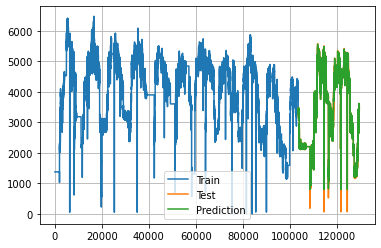

In [10]:
# test set prediction and model evaluation

# data should be re scaled to get the proper values
power_train = scaler.inverse_transform(np.array(power_train).reshape(-1,1))
power_test = scaler.inverse_transform(np.array(power_test).reshape(-1,1))

predictions = scaler.inverse_transform(mean_predictions).reshape(-1,1)


plt.plot(power_train,label='Train')

x_test = np.arange(len(power_train)+1,(len(power_train)+len(power_test)+1))
x_pred = np.arange(len(power_train),(len(power_train)+len(predictions)))
plt.plot(x_test,power_test,label='Test')
plt.plot(x_pred,predictions,label='Prediction')
plt.legend()
plt.grid()
plt.show()

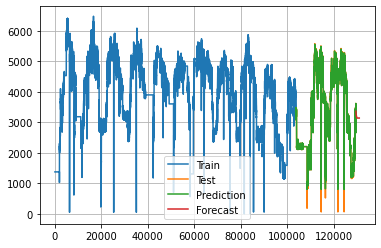

In [11]:
# forecasting

forecast = scaler.inverse_transform(np.array(mean_forecasts).reshape(-1,1))
#forecast

plt.plot(power_train,label='Train')

x_test = np.arange(len(power_train)+1,(len(power_train)+len(power_test)+1))
plt.plot(x_test,power_test,label='Test')

x_pred = np.arange((len(power_train)+1),(len(power_train)+len(power_test)))
plt.plot(x_pred,predictions,label='Prediction')

x_forecast = np.arange(len(power_data)+1,len(power_data)+num_forecast+2)
plt.plot(x_forecast,forecast,label='Forecast')
plt.legend()
plt.grid()
plt.show()

In [12]:
# hourly forecast

hours = []
hour = []
h = 0
for i in forecast: 
    
    hour.append(i)
    h += 1
    
    if h%60 == 0:
        hours.append(hour)
        hour = []
    else:
        hour.append(i)
        
hourly_forecast = [np.mean(i) for i in hours]

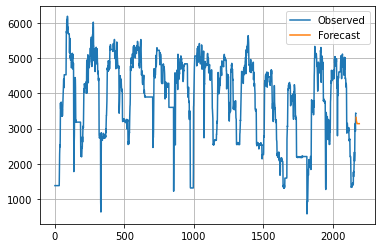

In [13]:
# hourly forecast plot

df_hourly_0 = df0.groupby(pd.Grouper(level='Time',freq='H')).mean()
df_hourly_0 = df_hourly_0.dropna()

plt.plot(df_hourly_0.values,label='Observed')

x_range = np.arange(len(df_hourly_0)+1,len(df_hourly_0)+25)
plt.plot(x_range,hourly_forecast,label='Forecast')
plt.legend()
plt.grid()
plt.show()



In [14]:
hourly_forecast

[3318.350772906652,
 3277.675607800585,
 3229.7359783792194,
 3208.306586460255,
 3190.96503210789,
 3172.5140399903817,
 3147.585355812462,
 3140.733773271677,
 3140.9775500718283,
 3141.004572644354,
 3140.980391386276,
 3140.9520252753696,
 3140.9298523509206,
 3140.9165074662,
 3140.9092323453474,
 3140.905553508905,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638]

### Dataset 1

In [15]:
# defining dataset 1 as all the observations gathered since 3 months prior to date to forcast (16-01-2020)

df1 = df['2019-10-15':'2020-01-15']
df1

,Power
Time,
2019-10-15 00:00:00,4405.0
2019-10-15 00:01:00,4275.0
2019-10-15 00:02:00,4391.5
2019-10-15 00:03:00,4441.5
2019-10-15 00:04:00,4390.5
...,...
2020-01-15 23:55:00,3117.0
2020-01-15 23:56:00,3150.0
2020-01-15 23:57:00,3155.5


In [16]:
# scale the data

scaler = MinMaxScaler(feature_range=(0,1))
df1_scaled = scaler.fit_transform(df1['Power'].values.reshape(-1,1)) #MinMax require a bidimensional imput so we have to reshape

df1_scaled

array([[0.7508736 ],
       [0.72871388],
       [0.7485724 ],
       ...,
       [0.5378846 ],
       [0.53515725],
       [0.52510014]])

In [17]:
# train - test splitting and reshaping for LSTM

power_data = df1_scaled
#power_data = power_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(power_data))

power_train = power_data[:split]
power_test = power_data[split:]

#date_train = df1[:split]
#date_test = df1[split:]

print(len(power_train))
print(len(power_test))

104225
26057


In [18]:
# generating suited dataset for LSTM (loopback datafrrame)

look_back = 1

train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(power_train, power_train, length=look_back, batch_size=32)     
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(power_test, power_test, length=look_back, batch_size=1)


In [19]:
# model defining and fitting


model1 = Sequential()
model1.add(
    LSTM(100,
        activation='relu',
        input_shape=(look_back,1))
)
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

num_epochs = 25
k = 10
num_forecast = 60*24
results = []
predictions = []
forecasts = []

def predict(num_prediction, model):
    prediction_list = power_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# process repetition for robustness puropses 
for i in range(k):
    hist = model1.fit_generator(train_generator, epochs=num_epochs, verbose=1,validation_data=test_generator)
    results.append(hist)
    
    prediction = model1.predict_generator(test_generator)
    predictions.append(prediction)
    
    
    forecast = predict(num_forecast, model1)
    forecasts.append(forecast)
    
    
    
    

Epoch 1/25
3257/3257 [==============================] - 29s 9ms/step - loss: 0.0088 - root_mean_squared_error: 0.1641 - val_loss: 1.4315e-06 - val_root_mean_squared_error: 0.0890
Epoch 2/25
3257/3257 [==============================] - 27s 8ms/step - loss: 3.9492e-04 - root_mean_squared_error: 0.0729 - val_loss: 3.0398e-05 - val_root_mean_squared_error: 0.0628
Epoch 3/25
3257/3257 [==============================] - 29s 9ms/step - loss: 3.3163e-04 - root_mean_squared_error: 0.0566 - val_loss: 1.8286e-04 - val_root_mean_squared_error: 0.0518
Epoch 4/25
3257/3257 [==============================] - 30s 9ms/step - loss: 3.2938e-04 - root_mean_squared_error: 0.0484 - val_loss: 2.2017e-04 - val_root_mean_squared_error: 0.0455
Epoch 5/25
3257/3257 [==============================] - 30s 9ms/step - loss: 3.2823e-04 - root_mean_squared_error: 0.0433 - val_loss: 1.4419e-04 - val_root_mean_squared_error: 0.0414
Epoch 6/25
3257/3257 [==============================] - 30s 9ms/step - loss: 3.2648e-04 -

3257/3257 [==============================] - 29s 9ms/step - loss: 3.2301e-04 - root_mean_squared_error: 0.0192 - val_loss: 1.2395e-04 - val_root_mean_squared_error: 0.0192
Epoch 15/25
3257/3257 [==============================] - 35s 11ms/step - loss: 3.2120e-04 - root_mean_squared_error: 0.0191 - val_loss: 7.7162e-05 - val_root_mean_squared_error: 0.0191
Epoch 16/25
3257/3257 [==============================] - 32s 10ms/step - loss: 3.2141e-04 - root_mean_squared_error: 0.0191 - val_loss: 7.2349e-05 - val_root_mean_squared_error: 0.0191
Epoch 17/25
3257/3257 [==============================] - 27s 8ms/step - loss: 3.2291e-04 - root_mean_squared_error: 0.0191 - val_loss: 1.0109e-04 - val_root_mean_squared_error: 0.0191
Epoch 18/25
3257/3257 [==============================] - 29s 9ms/step - loss: 3.2200e-04 - root_mean_squared_error: 0.0191 - val_loss: 1.4040e-04 - val_root_mean_squared_error: 0.0191
Epoch 19/25
3257/3257 [==============================] - 35s 11ms/step - loss: 3.2099e-04 

3257/3257 [==============================] - 29s 9ms/step - loss: 3.2094e-04 - root_mean_squared_error: 0.0186 - val_loss: 7.1516e-05 - val_root_mean_squared_error: 0.0186
Epoch 3/25
3257/3257 [==============================] - 30s 9ms/step - loss: 3.2027e-04 - root_mean_squared_error: 0.0186 - val_loss: 1.0549e-04 - val_root_mean_squared_error: 0.0186
Epoch 4/25
3257/3257 [==============================] - 33s 10ms/step - loss: 3.2044e-04 - root_mean_squared_error: 0.0186 - val_loss: 6.0172e-05 - val_root_mean_squared_error: 0.0186
Epoch 5/25
3257/3257 [==============================] - 32s 10ms/step - loss: 3.2061e-04 - root_mean_squared_error: 0.0186 - val_loss: 7.9312e-05 - val_root_mean_squared_error: 0.0186
Epoch 6/25
3257/3257 [==============================] - 33s 10ms/step - loss: 3.2082e-04 - root_mean_squared_error: 0.0186 - val_loss: 9.4117e-05 - val_root_mean_squared_error: 0.0186
Epoch 7/25
3257/3257 [==============================] - 39s 12ms/step - loss: 3.2089e-04 - ro

In [20]:
# model performances evaluation

loss = []
val_loss = []
rmses = []
val_rmses = []

for i in range(k):
    loss.append(results[i].history['loss'])
    val_loss.append(results[i].history['val_loss'])
    rmses.append(results[i].history['root_mean_squared_error'])
    val_rmses.append(results[i].history['val_root_mean_squared_error'])


In [21]:
mean_loss = np.mean(val_loss)
mean_rmses = np.mean(rmses)

mean_val_loss = np.mean(val_loss)
mean_val_rmses = np.mean(val_rmses)

mean_predictions = np.mean(predictions,axis=0)
mean_forecasts = np.mean(forecasts,axis=0)

In [22]:
max_value = df1_scaled.max() - df1_scaled.min()
print('Train Model Fit %:',np.round((1-(mean_rmses/max_value)) * 100,4))
print('Validation Model Fit %:',np.round((1-(mean_val_rmses/max_value)) * 100,4))

Train Model Fit %: 97.8863
Validation Model Fit %: 97.9287


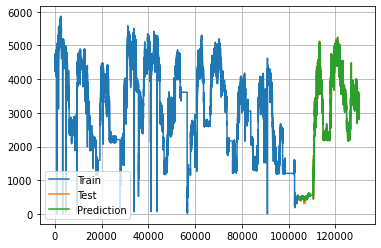

In [23]:
# test set prediction and model evaluation

# data should be rescaled to get the proper values
power_train = scaler.inverse_transform(np.array(power_train).reshape(-1,1))
power_test = scaler.inverse_transform(np.array(power_test).reshape(-1,1))

predictions = scaler.inverse_transform(mean_predictions).reshape(-1,1)


plt.plot(power_train,label='Train')

x_test = np.arange(len(power_train)+1,(len(power_train)+len(power_test)+1))
x_pred = np.arange(len(power_train),(len(power_train)+len(predictions)))
plt.plot(x_test,power_test,label='Test')
plt.plot(x_pred,predictions,label='Prediction')
plt.legend()
plt.grid()
plt.show()

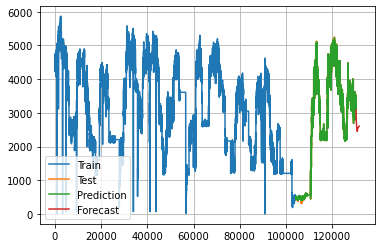

In [24]:
# forecasting

forecast = scaler.inverse_transform(np.array(mean_forecasts).reshape(-1,1))
#forecast

plt.plot(power_train,label='Train')

x_test = np.arange(len(power_train)+1,(len(power_train)+len(power_test)+1))
plt.plot(x_test,power_test,label='Test')

x_pred = np.arange((len(power_train)+1),(len(power_train)+len(power_test)))
plt.plot(x_pred,predictions,label='Prediction')

x_forecast = np.arange(len(power_data)+1,len(power_data)+num_forecast+2)
plt.plot(x_forecast,forecast,label='Forecast')
plt.legend()
plt.grid()
plt.show()

In [25]:
# hourly forecast

hours = []
hour = []
h = 0
for i in forecast: 
    
    hour.append(i)
    h += 1
    
    if h%60 == 0:
        hours.append(hour)
        hour = []
    else:
        hour.append(i)
        
hourly_forecast = [np.mean(i) for i in hours]

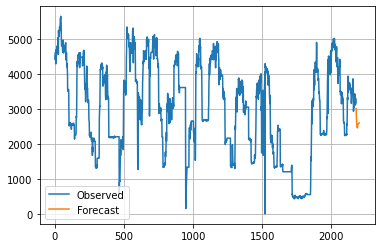

In [26]:
# hourly forecast plot

df_hourly_1 = df1.groupby(pd.Grouper(level='Time',freq='H')).mean()
df_hourly_1 = df_hourly_1.dropna()

plt.plot(df_hourly_1.values,label='Observed')

x_range = np.arange(len(df_hourly_1)+1,len(df_hourly_1)+25)
plt.plot(x_range,hourly_forecast,label='Forecast')
plt.legend()
plt.grid()
plt.show()


In [27]:
hourly_forecast

[3004.0446553850365,
 2879.791371727303,
 2760.4152536301076,
 2689.5779713138436,
 2627.5398778907866,
 2558.832761691517,
 2510.8630168745676,
 2480.3099934077227,
 2457.2312571506636,
 2457.149310989377,
 2477.4315939562816,
 2504.197806426678,
 2536.725627020198,
 2553.581067513289,
 2559.623175039659,
 2564.457482534219,
 2569.114596337578,
 2573.7055747861345,
 2578.257836466349,
 2582.788682435461,
 2587.314211647672,
 2591.851096634575,
 2596.4159302968915,
 2601.0248556649453]

### Dataset 2

In [28]:
# defining dataset 2 as all the observations gathered since 3 months prior to date to forcast (18-06-2020)


df2 = df['2020-03-17':'2020-06-17']
df2

,Power
Time,
2020-03-17 00:00:00,5257.0
2020-03-17 00:01:00,5206.0
2020-03-17 00:02:00,5181.0
2020-03-17 00:03:00,5226.5
2020-03-17 00:04:00,5117.0
...,...
2020-06-17 23:55:00,3882.0
2020-06-17 23:56:00,3882.0
2020-06-17 23:57:00,3882.0


In [29]:
# scale the data

scaler = MinMaxScaler(feature_range=(0,1))
df2_scaled = scaler.fit_transform(df2['Power'].values.reshape(-1,1)) #MinMax require a bidimensional imput so we have to reshape

df2_scaled

array([[0.90094259],
       [0.89220223],
       [0.88791774],
       ...,
       [0.66529563],
       [0.66529563],
       [0.66529563]])

In [30]:
# train - test splitting and reshaping for LSTM

power_data = df2_scaled
#power_data = power_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(power_data))

power_train = power_data[:split]
power_test = power_data[split:]

#date_train = df1[:split]
#date_test = df1[split:]

print(len(power_train))
print(len(power_test))

99274
24819


In [31]:
# generating suited dataset for LSTM (loopback datafrrame)

look_back = 1

train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(power_train, power_train, length=look_back, batch_size=32)     
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(power_test, power_test, length=look_back, batch_size=1)

In [32]:
# model fitting


model2 = Sequential()
model2.add(
    LSTM(100,
        activation='relu',
        input_shape=(look_back,1))
)
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

num_epochs = 25
k = 10
num_forecast = 60*24
results = []
predictions = []
forecasts = []

def predict(num_prediction, model):
    prediction_list = power_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# process repetition for robustness puropses 

for i in range(k):
    hist = model2.fit_generator(train_generator, epochs=num_epochs, verbose=1,validation_data=test_generator)
    results.append(hist)
    
    prediction = model2.predict_generator(test_generator)
    predictions.append(prediction)
    
    
    forecast = predict(num_forecast, model2)
    forecasts.append(forecast)

Epoch 1/25
3103/3103 [==============================] - 18s 6ms/step - loss: 0.0116 - root_mean_squared_error: 0.1923 - val_loss: 1.0127e-06 - val_root_mean_squared_error: 0.1020
Epoch 2/25
3103/3103 [==============================] - 17s 6ms/step - loss: 4.4524e-04 - root_mean_squared_error: 0.0835 - val_loss: 6.5861e-06 - val_root_mean_squared_error: 0.0719
Epoch 3/25
3103/3103 [==============================] - 17s 6ms/step - loss: 4.4526e-04 - root_mean_squared_error: 0.0648 - val_loss: 1.2607e-07 - val_root_mean_squared_error: 0.0595
Epoch 4/25
3103/3103 [==============================] - 17s 6ms/step - loss: 4.3464e-04 - root_mean_squared_error: 0.0556 - val_loss: 7.1254e-07 - val_root_mean_squared_error: 0.0524
Epoch 5/25
3103/3103 [==============================] - 17s 6ms/step - loss: 4.2486e-04 - root_mean_squared_error: 0.0499 - val_loss: 2.8293e-08 - val_root_mean_squared_error: 0.0477
Epoch 6/25
3103/3103 [==============================] - 17s 5ms/step - loss: 4.1874e-04 -

3103/3103 [==============================] - 25s 8ms/step - loss: 3.9539e-04 - root_mean_squared_error: 0.0227 - val_loss: 1.2705e-09 - val_root_mean_squared_error: 0.0227
Epoch 15/25
3103/3103 [==============================] - 27s 9ms/step - loss: 3.9410e-04 - root_mean_squared_error: 0.0227 - val_loss: 5.3933e-07 - val_root_mean_squared_error: 0.0227
Epoch 16/25
3103/3103 [==============================] - 27s 9ms/step - loss: 3.9471e-04 - root_mean_squared_error: 0.0227 - val_loss: 1.5334e-06 - val_root_mean_squared_error: 0.0226
Epoch 17/25
3103/3103 [==============================] - 31s 10ms/step - loss: 3.9536e-04 - root_mean_squared_error: 0.0226 - val_loss: 1.2385e-06 - val_root_mean_squared_error: 0.0226
Epoch 18/25
3103/3103 [==============================] - 29s 9ms/step - loss: 3.9548e-04 - root_mean_squared_error: 0.0226 - val_loss: 3.2522e-06 - val_root_mean_squared_error: 0.0226
Epoch 19/25
3103/3103 [==============================] - 27s 9ms/step - loss: 3.9494e-04 - 

3103/3103 [==============================] - 20s 7ms/step - loss: 3.9463e-04 - root_mean_squared_error: 0.0221 - val_loss: 1.6373e-05 - val_root_mean_squared_error: 0.0221
Epoch 3/25
3103/3103 [==============================] - 17s 5ms/step - loss: 3.9452e-04 - root_mean_squared_error: 0.0221 - val_loss: 5.0227e-06 - val_root_mean_squared_error: 0.0221
Epoch 4/25
3103/3103 [==============================] - 16s 5ms/step - loss: 3.9366e-04 - root_mean_squared_error: 0.0221 - val_loss: 2.1988e-05 - val_root_mean_squared_error: 0.0221
Epoch 5/25
3103/3103 [==============================] - 16s 5ms/step - loss: 3.9452e-04 - root_mean_squared_error: 0.0221 - val_loss: 1.0314e-05 - val_root_mean_squared_error: 0.0221
Epoch 6/25
3103/3103 [==============================] - 17s 5ms/step - loss: 3.9370e-04 - root_mean_squared_error: 0.0221 - val_loss: 2.1615e-06 - val_root_mean_squared_error: 0.0221
Epoch 7/25
3103/3103 [==============================] - 17s 5ms/step - loss: 3.9374e-04 - root_m

Epoch 22/25
3103/3103 [==============================] - 17s 5ms/step - loss: 3.9478e-04 - root_mean_squared_error: 0.0222 - val_loss: 1.2481e-06 - val_root_mean_squared_error: 0.0222
Epoch 23/25
3103/3103 [==============================] - 16s 5ms/step - loss: 3.9449e-04 - root_mean_squared_error: 0.0222 - val_loss: 4.5198e-06 - val_root_mean_squared_error: 0.0222
Epoch 24/25
3103/3103 [==============================] - 16s 5ms/step - loss: 3.9444e-04 - root_mean_squared_error: 0.0222 - val_loss: 4.1338e-06 - val_root_mean_squared_error: 0.0222
Epoch 25/25
3103/3103 [==============================] - 16s 5ms/step - loss: 3.9383e-04 - root_mean_squared_error: 0.0222 - val_loss: 4.3839e-05 - val_root_mean_squared_error: 0.0222
Epoch 1/25
3103/3103 [==============================] - 16s 5ms/step - loss: 3.9431e-04 - root_mean_squared_error: 0.0222 - val_loss: 1.8376e-07 - val_root_mean_squared_error: 0.0222
Epoch 2/25
3103/3103 [==============================] - 17s 5ms/step - loss: 3.93

In [33]:
# model performances

loss = []
val_loss = []
rmses = []
val_rmses = []

for i in range(k):
    loss.append(results[i].history['loss'])
    val_loss.append(results[i].history['val_loss'])
    rmses.append(results[i].history['root_mean_squared_error'])
    val_rmses.append(results[i].history['val_root_mean_squared_error'])

In [34]:
mean_loss = np.mean(val_loss)
mean_rmses = np.mean(rmses)

mean_val_loss = np.mean(val_loss)
mean_val_rmses = np.mean(val_rmses)

mean_predictions = np.mean(predictions,axis=0)
mean_forecasts = np.mean(forecasts,axis=0)

In [35]:
max_value = df2_scaled.max() - df2_scaled.min()
print('Train Model Fit %:',np.round((1-(mean_rmses/max_value)) * 100,4))
print('Validation Model Fit %:',np.round((1-(mean_val_rmses/max_value)) * 100,4))

Train Model Fit %: 97.5053
Validation Model Fit %: 97.5549


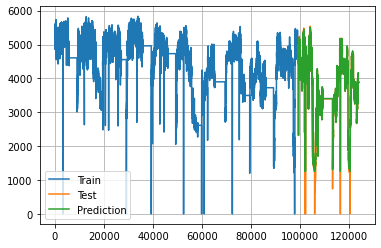

In [36]:
# test set prediction and model evaluation

# data should be re scaled to get the proper values
power_train = scaler.inverse_transform(np.array(power_train).reshape(-1,1))
power_test = scaler.inverse_transform(np.array(power_test).reshape(-1,1))

predictions = scaler.inverse_transform(mean_predictions).reshape(-1,1)


plt.plot(power_train,label='Train')

x_test = np.arange(len(power_train)+1,(len(power_train)+len(power_test)+1))
x_pred = np.arange(len(power_train),(len(power_train)+len(predictions)))
plt.plot(x_test,power_test,label='Test')
plt.plot(x_pred,predictions,label='Prediction')
plt.legend()
plt.grid()
plt.show()

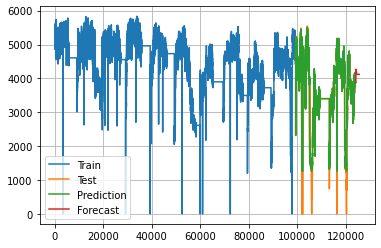

In [37]:
# forecasting

forecast = scaler.inverse_transform(np.array(mean_forecasts).reshape(-1,1))
#forecast

plt.plot(power_train,label='Train')

x_test = np.arange(len(power_train)+1,(len(power_train)+len(power_test)+1))
plt.plot(x_test,power_test,label='Test')

x_pred = np.arange((len(power_train)+1),(len(power_train)+len(predictions))+1)
plt.plot(x_pred,predictions,label='Prediction')

x_forecast = np.arange(len(power_data)+1,len(power_data)+num_forecast+2)
plt.plot(x_forecast,forecast,label='Forecast')
plt.legend()
plt.grid()
plt.show()

In [38]:
# hourly forecast

hours = []
hour = []
h = 0
for i in forecast: 
    
    hour.append(i)
    h += 1
    
    if h%60 == 0:
        hours.append(hour)
        hour = []
    else:
        hour.append(i)
        
hourly_forecast = [np.mean(i) for i in hours]

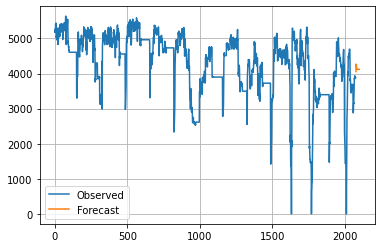

In [39]:
# hourly forecasting plot

df_hourly_2 = df2.groupby(pd.Grouper(level='Time',freq='H')).mean()
df_hourly_2 = df_hourly_2.dropna()

plt.plot(df_hourly_2.values,label='Observed')

x_range = np.arange(len(df_hourly_2)+1,len(df_hourly_2)+25)
plt.plot(x_range,hourly_forecast,label='Forecast')
plt.legend()
plt.grid()
plt.show()

In [40]:
hourly_forecast

[4055.123400239759,
 4267.636974587911,
 4252.260471623736,
 4232.958047679993,
 4201.725059505521,
 4130.0386414375125,
 4121.550493877475,
 4120.9815765511585,
 4120.568688562938,
 4120.253652894698,
 4120.009357174405,
 4119.8173835653215,
 4119.664877459031,
 4119.542738366778,
 4119.444534746539,
 4119.365058177409,
 4119.300298224978,
 4119.2473772666535,
 4119.20414921441,
 4119.168673148926,
 4119.1396029063135,
 4119.115803921172,
 4119.096037874702,
 4119.07989296818]

### Below are reported the final result just as an easy way to take them for further operation in the next notebook regarding Power optimization and cost minimization



In [46]:
hourly_19_11_2019 = [3318.350772906652,
 3277.675607800585,
 3229.7359783792194,
 3208.306586460255,
 3190.96503210789,
 3172.5140399903817,
 3147.585355812462,
 3140.733773271677,
 3140.9775500718283,
 3141.004572644354,
 3140.980391386276,
 3140.9520252753696,
 3140.9298523509206,
 3140.9165074662,
 3140.9092323453474,
 3140.905553508905,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638,
 3140.905003702638]

hourly_16_01_2020 = [3004.0446553850365,
 2879.791371727303,
 2760.4152536301076,
 2689.5779713138436,
 2627.5398778907866,
 2558.832761691517,
 2510.8630168745676,
 2480.3099934077227,
 2457.2312571506636,
 2457.149310989377,
 2477.4315939562816,
 2504.197806426678,
 2536.725627020198,
 2553.581067513289,
 2559.623175039659,
 2564.457482534219,
 2569.114596337578,
 2573.7055747861345,
 2578.257836466349,
 2582.788682435461,
 2587.314211647672,
 2591.851096634575,
 2596.4159302968915,
 2601.0248556649453]

hourly_18_06_2020 = [4055.123400239759,
 4267.636974587911,
 4252.260471623736,
 4232.958047679993,
 4201.725059505521,
 4130.0386414375125,
 4121.550493877475,
 4120.9815765511585,
 4120.568688562938,
 4120.253652894698,
 4120.009357174405,
 4119.8173835653215,
 4119.664877459031,
 4119.542738366778,
 4119.444534746539,
 4119.365058177409,
 4119.300298224978,
 4119.2473772666535,
 4119.20414921441,
 4119.168673148926,
 4119.1396029063135,
 4119.115803921172,
 4119.096037874702,
 4119.07989296818]

